In [1]:
from codey_functions import *
from scipy.signal import find_peaks
import numpy as np
from sklearn.neighbors import NearestNeighbors

dunky_df = pd.read_csv('datasets/dunking-data.csv')
dunky_df['L_sqrd'] = dunky_df['L']**2
dunky_df['1/t'] = 1/dunky_df['t']

dunky_df['r'] = (dunky_df['L_sqrd'] * (2*dunky_df['eta']))/(dunky_df['gamma'] * dunky_df['t'] * np.cos(dunky_df['phi']))

dunky_df

,gamma,phi,eta,L,t,biscuit,L_sqrd,1/t,r
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive,0.000125,0.051647,7.429094e-07
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,0.000035,0.084370,7.803690e-07
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,0.000086,0.040333,8.302559e-07
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,0.000014,0.061377,3.598074e-07
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,0.000005,0.073194,5.814437e-07
...,...,...,...,...,...,...,...,...,...
2995,0.084596,1.557367,0.000981,0.003221,24.231107,Digestive,0.000010,0.041269,7.396247e-07
2996,0.067928,1.487239,0.000993,0.003933,12.256570,Hobnob,0.000015,0.081589,4.421999e-07
2997,0.059526,1.444489,0.000998,0.007583,26.464108,Hobnob,0.000057,0.037787,5.781880e-07
2998,0.071386,1.212213,0.001004,0.013988,22.772293,Digestive,0.000196,0.043913,6.883535e-07


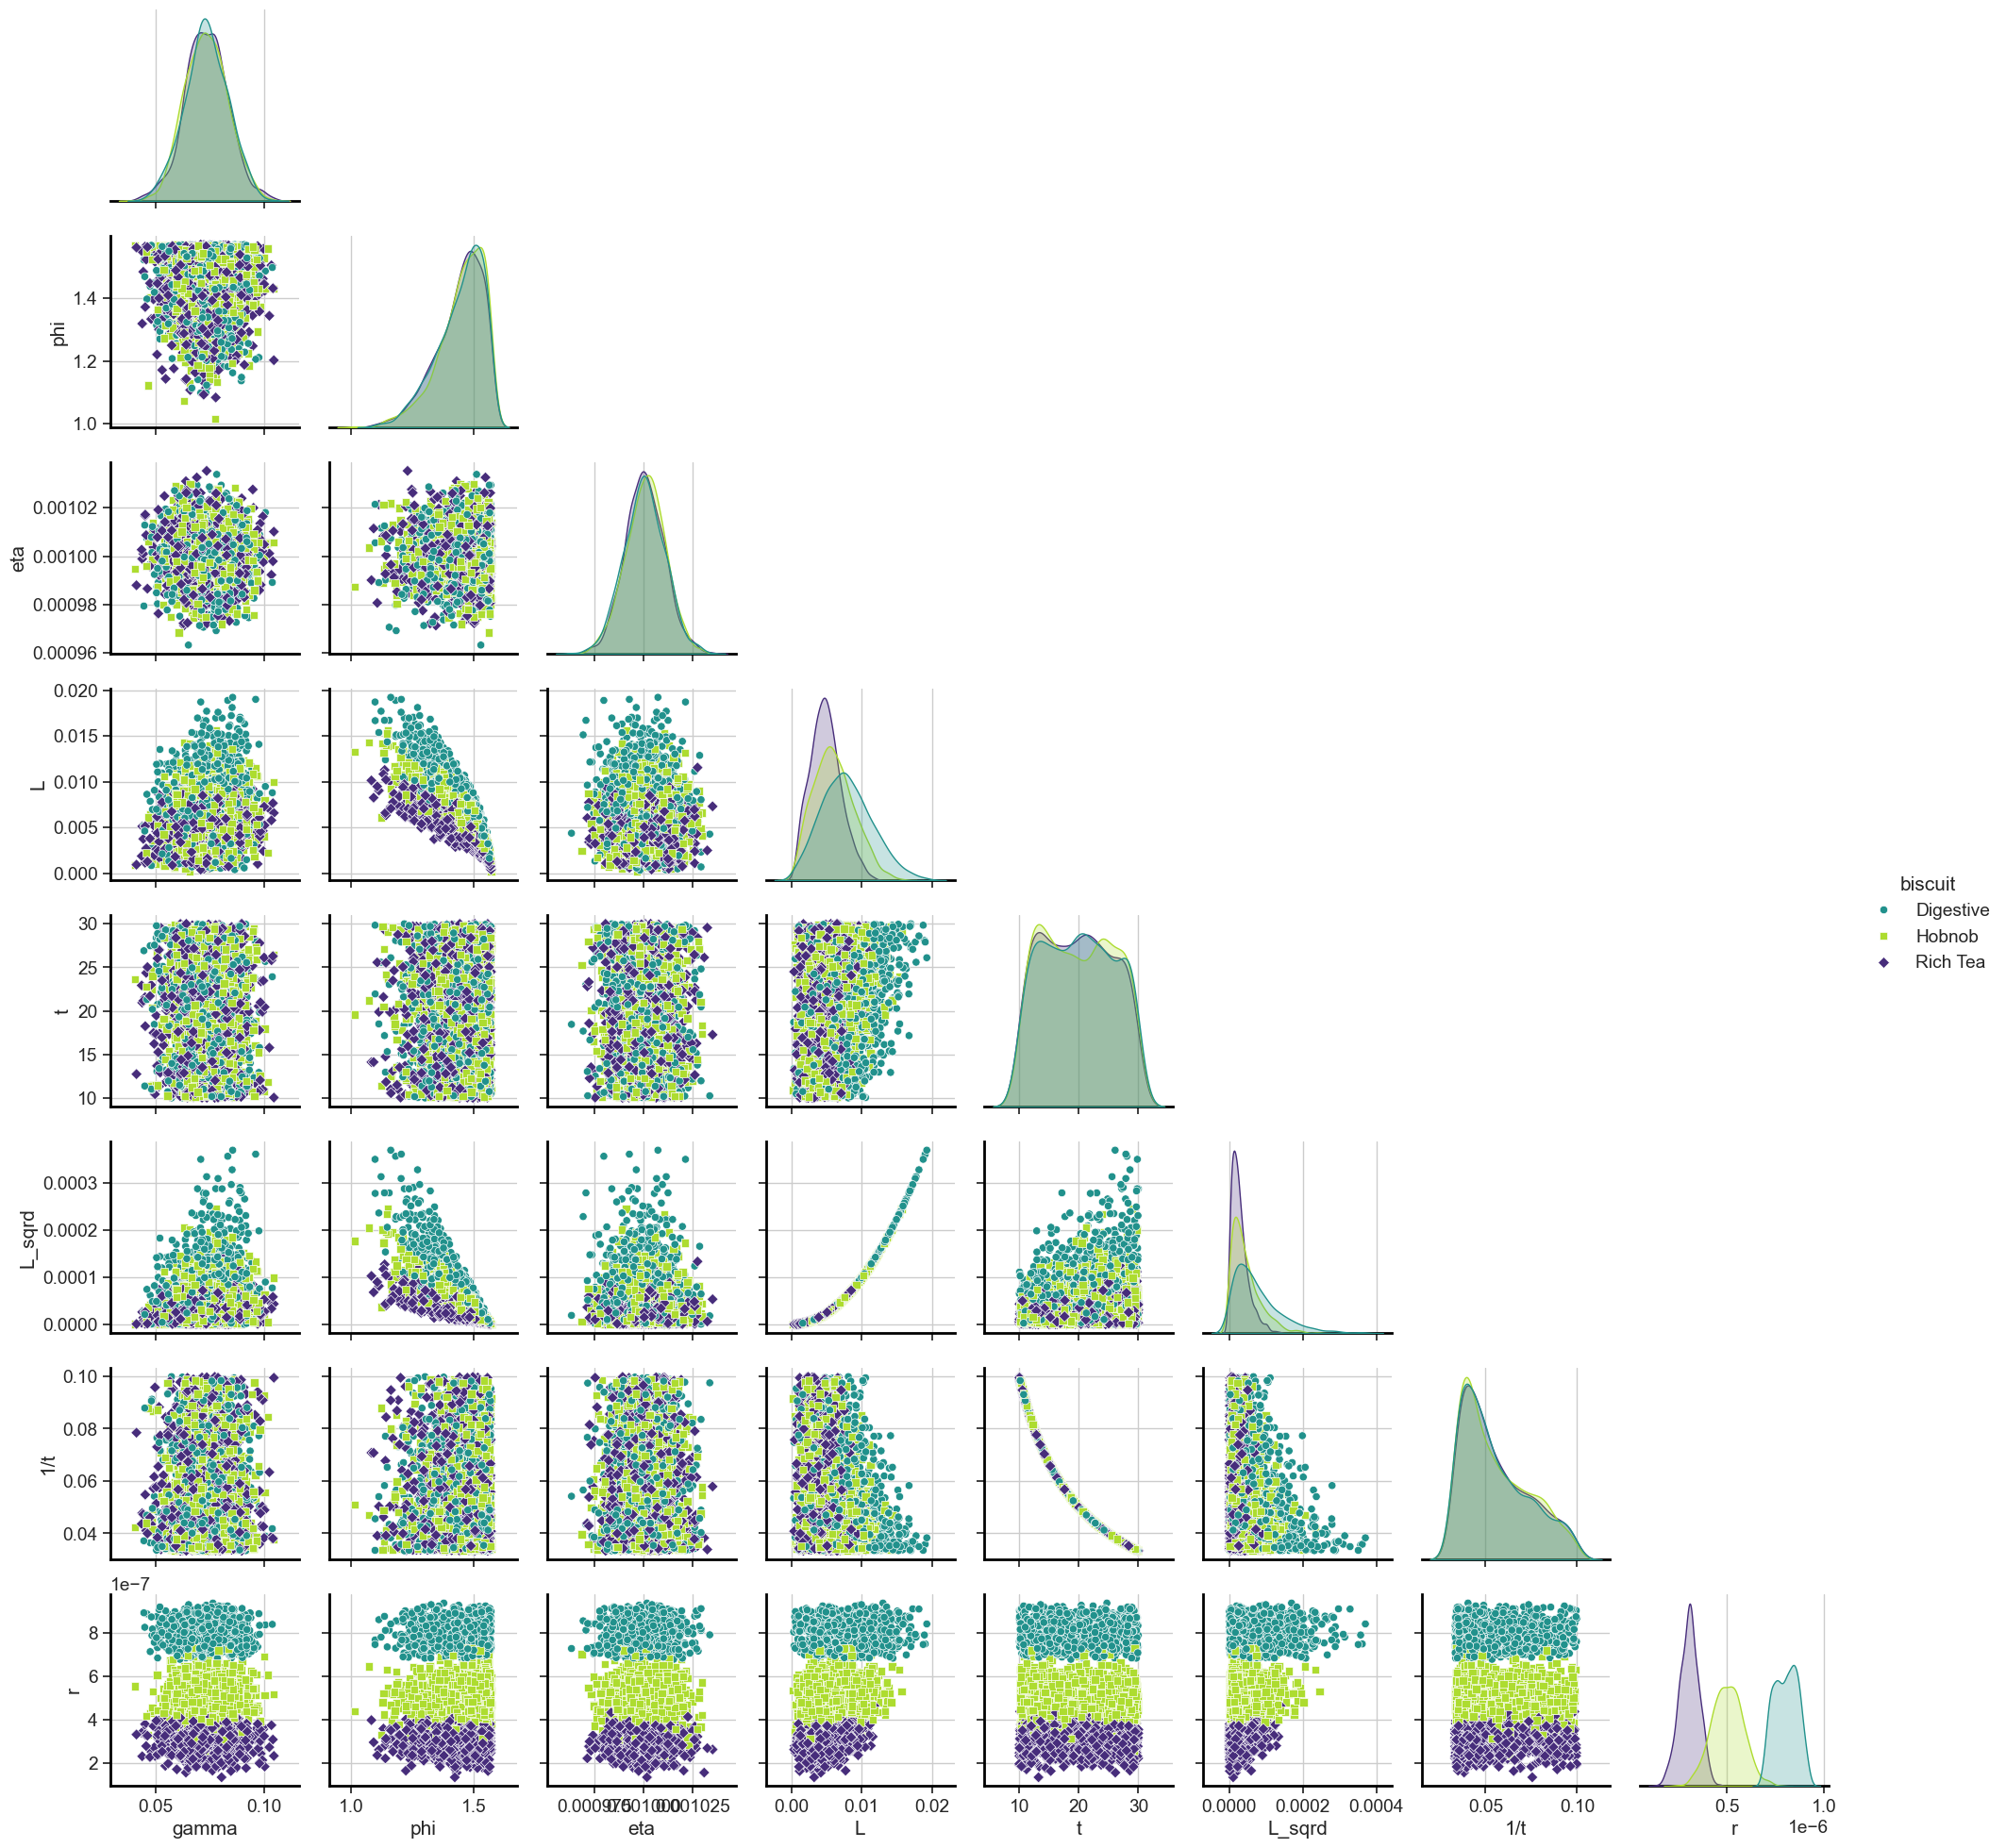

In [2]:
sns.pairplot(dunky_df, diag_kind='kde', hue='biscuit', corner = True, markers=["o", "s", "D"])

<Axes: xlabel='r', ylabel='Density'>

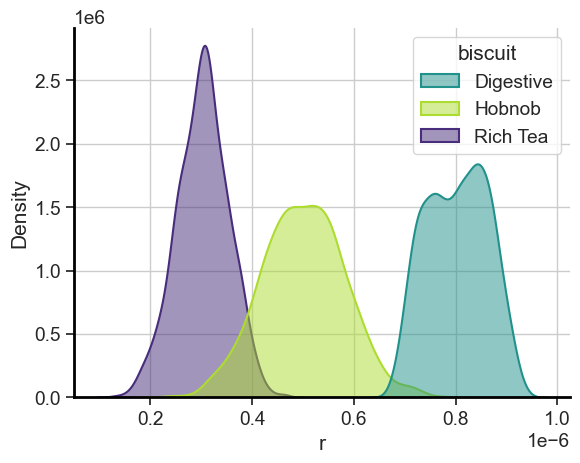

In [94]:
sns.kdeplot(
   data=dunky_df, x="r", hue="biscuit",
   fill=True, common_norm=True, alpha=.5, linewidth=1.5, bw_adjust=1
)

There is a level of inconsistency here, I want to try and make something the user can use to identify if the biscuit type has inconsistencies and what that might quantify too in terms of effecting the value of L

In [12]:
def mode_trace_func(number_of_modes, bw_values, dataset_values, precentage_range, minimum_range):
    mode_value = 1
    count = 0
    store_peaks = []
    evolution_of_peaks = {}
    
    upper_percent = 1 + precentage_range
    lower_percent = 1 - precentage_range
    
    for i in bw_values:
        density = sns.kdeplot(dataset_values, bw_adjust=i).get_lines()[count].get_data()
        count += 1
        
        peaks, _ = find_peaks(density[1], prominence=(minimum_range, None))  # density[1] contains the y-values of the KDE
        
        # Stores all possible modes found in the KDE
        for value in peaks:
            store_peaks.append([density[0][value], i])
            
        # If no modes have been found yet, add all peaks to the dictionary (these are the first modes found in the KDE)
        if evolution_of_peaks == {}:
            for value in peaks:
                evolution_of_peaks[f'Mode {mode_value}'] = [[density[0][value],i]]
                # Mode value keeps track of the number of modes found
                mode_value += 1
        # If modes have been found, add new peaks to the dictionary if they are close to the previous peaks
        else:
            # peaks just added lets us know which peaks have been added to the dictionary so if the number of modes are not reached, we can make a new mode without repeating peaks
            peaks_just_added = []
            # First we add the peaks that are close to the previous peaks
            for key in evolution_of_peaks.keys():
                for item in density[0][peaks]:
                    # The peaks are added if they are within 0.5% of the previous peak
                    if (item < evolution_of_peaks[key][-1][0]*upper_percent) and (item > evolution_of_peaks[key][-1][0]*lower_percent):
                        evolution_of_peaks[key].append([item,i])
                        peaks_just_added.append(item)
                            
            # If the number of modes have not been reached, add new modes with the remaining peaks               
            if mode_value <= number_of_modes:
                if len(np.setdiff1d(density[0][peaks], peaks_just_added)) > 0:
                    for item in np.setdiff1d(density[0][peaks], peaks_just_added):
                        evolution_of_peaks[f'Mode {mode_value}'] = [[item,i]]
                        mode_value += 1
            
    plt.close()
    
    return evolution_of_peaks, store_peaks

In [4]:
digestive_df = dunky_df[dunky_df['biscuit'] == 'Digestive']
richtea_df = dunky_df[dunky_df['biscuit'] == 'Rich Tea']
hobnob_df = dunky_df[dunky_df['biscuit'] == 'Hobnob']

In [ ]:
from ipywidgets import interact, interactive, HBox, VBox, interactive_output

from IPython.display import display

In [ ]:
def bandwidth_widget(df_column, bw=10):
    sns.kdeplot(df_column, bw_method=bw, lw=3, fill=True)
    plt.xlim(-30, 300)
    plt.ylim(0, 0.03)

In [ ]:
interactive(bandwidth_widget, bw=(0.05, 1.5, 0.001))

interactive(children=(FloatSlider(value=1.5, description='bw', max=1.5, min=0.05, step=0.001), Output()), _dom…

In [5]:
bw_values = np.arange(2, 0.01, -0.01)

bw_values

array([2.  , 1.99, 1.98, 1.97, 1.96, 1.95, 1.94, 1.93, 1.92, 1.91, 1.9 ,
       1.89, 1.88, 1.87, 1.86, 1.85, 1.84, 1.83, 1.82, 1.81, 1.8 , 1.79,
       1.78, 1.77, 1.76, 1.75, 1.74, 1.73, 1.72, 1.71, 1.7 , 1.69, 1.68,
       1.67, 1.66, 1.65, 1.64, 1.63, 1.62, 1.61, 1.6 , 1.59, 1.58, 1.57,
       1.56, 1.55, 1.54, 1.53, 1.52, 1.51, 1.5 , 1.49, 1.48, 1.47, 1.46,
       1.45, 1.44, 1.43, 1.42, 1.41, 1.4 , 1.39, 1.38, 1.37, 1.36, 1.35,
       1.34, 1.33, 1.32, 1.31, 1.3 , 1.29, 1.28, 1.27, 1.26, 1.25, 1.24,
       1.23, 1.22, 1.21, 1.2 , 1.19, 1.18, 1.17, 1.16, 1.15, 1.14, 1.13,
       1.12, 1.11, 1.1 , 1.09, 1.08, 1.07, 1.06, 1.05, 1.04, 1.03, 1.02,
       1.01, 1.  , 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91,
       0.9 , 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 ,
       0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69,
       0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58,
       0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.

In [108]:
dataset_values = hobnob_df['t']
number_of_modes = 2

evolution_of_peaks, store_peaks = mode_trace_func(number_of_modes, bw_values, dataset_values, 0.015, 0.001)

[13.47223044  1.01      ]
[24.00201806  0.95611111]


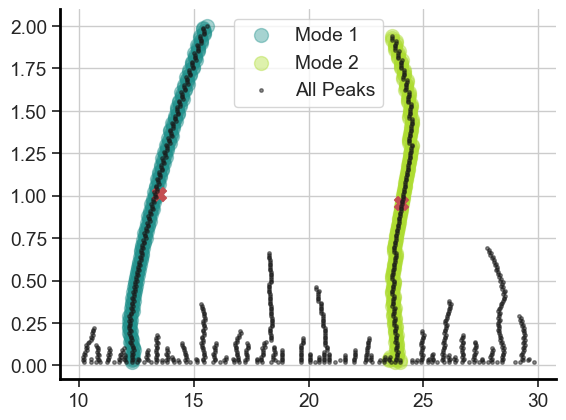

In [109]:
centroids = []
for key in evolution_of_peaks:
    evolution_of_peaks[key] = np.array(evolution_of_peaks[key])
    plt.scatter(evolution_of_peaks[key][:,0], evolution_of_peaks[key][:,1], label=key, alpha=0.4, s=100)
    center = np.mean(evolution_of_peaks[key], axis=0)
    print(center)
    centroids.append(center[0])
    plt.scatter(center[0], center[1], c='r', marker='X', s=100)
    
store_peaks = np.array(store_peaks)
centroids = np.array(centroids)
plt.scatter(store_peaks[:,0], store_peaks[:,1], marker='.', c='k', label='All Peaks', alpha=0.5, s=25)

plt.legend()
plt.show()

2


C:\Users\Fay\AppData\Local\Temp\ipykernel_25760\130018802.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hobnob_df['assigned_centroids'] = cat_assigned_centroids


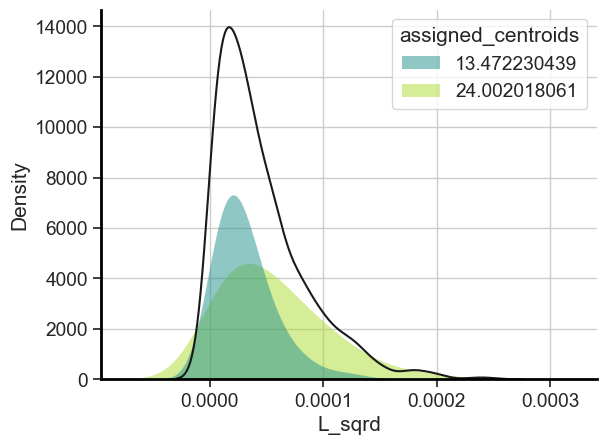

In [127]:
# Sample 1D data
data_points = dataset_values.values

# Initialize k-NN model
k = number_of_modes
knn_model = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(centroids.reshape(-1, 1))

print(knn_model.n_samples_fit_)

# Find nearest centroids
distances, indices = knn_model.kneighbors(data_points.reshape(-1, 1))

# Assign data points to centroids
assigned_centroids = centroids[indices[:, 0]]

cat_assigned_centroids = np.round(assigned_centroids, 9).astype(str)

hobnob_df['assigned_centroids'] = cat_assigned_centroids

sns.kdeplot(data=hobnob_df, x="L_sqrd", hue="assigned_centroids", fill=True, common_norm=True, alpha=.5, linewidth=0, bw_adjust=2)
sns.kdeplot(data=hobnob_df, x="L_sqrd", fill=False, common_norm=True, alpha=1, linewidth=1.5, bw_adjust=1, color='k')
# plt.axvline(assigned_centroids[0], 0,0.8, color = palette[0])
# plt.axvline(assigned_centroids[1], 0,0.94, color = palette[1])
# plt.axvline(assigned_centroids[2], 0,0.94, color = palette[2])
plt.show()

In [115]:
hobnob_df

,gamma,phi,eta,L,t,biscuit,L_sqrd,1/t,r,assigned_centroids
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,0.000014,0.061377,3.598074e-07,13.472230439
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,0.000005,0.073194,5.814437e-07,13.472230439
7,0.062276,1.520534,0.001005,0.004030,28.423407,Hobnob,0.000016,0.035182,3.671879e-07,24.002018061
9,0.076202,1.522457,0.000998,0.003811,19.176369,Hobnob,0.000015,0.052148,4.107470e-07,24.002018061
17,0.078570,1.437574,0.000989,0.004544,10.194653,Hobnob,0.000021,0.098091,3.839265e-07,13.472230439
...,...,...,...,...,...,...,...,...,...,...
2986,0.064065,1.527012,0.001020,0.003243,12.816238,Hobnob,0.000011,0.078026,5.971595e-07,13.472230439
2987,0.070954,1.447903,0.000996,0.005560,17.524261,Hobnob,0.000031,0.057064,4.038749e-07,13.472230439
2992,0.074691,1.504049,0.000998,0.005253,28.403373,Hobnob,0.000028,0.035207,3.891035e-07,24.002018061
2996,0.067928,1.487239,0.000993,0.003933,12.256570,Hobnob,0.000015,0.081589,4.421999e-07,13.472230439


In [116]:
hobnob_df['assigned_centroids'].value_counts()

assigned_centroids
24.002018061    544
13.472230439    456
Name: count, dtype: int64

In [117]:
hobnob_df.groupby('assigned_centroids')['t'].describe()

,count,mean,std,min,25%,50%,75%,max
assigned_centroids,,,,,,,,
13.472230439,456.0,14.307583,2.465487,10.107033,12.262445,14.116017,16.325392,18.731198
24.002018061,544.0,24.532652,3.207187,18.809013,21.964675,24.354851,27.320463,29.922937


In [120]:
hobnob_df.groupby('assigned_centroids')['L_sqrd'].describe()

,count,mean,std,min,25%,50%,75%,max
assigned_centroids,,,,,,,,
13.472230439,456.0,0.000031,0.000025,3.417788e-08,0.000012,0.000025,0.000041,0.000138
24.002018061,544.0,0.000056,0.000045,2.472650e-07,0.000020,0.000047,0.000081,0.000245


In [122]:
hobnob_df.groupby('assigned_centroids')['phi'].describe()

,count,mean,std,min,25%,50%,75%,max
assigned_centroids,,,,,,,,
13.472230439,456.0,1.452718,0.087276,1.122287,1.405652,1.468082,1.521675,1.570619
24.002018061,544.0,1.444280,0.099665,1.016252,1.381793,1.463260,1.522368,1.570269
